#  Student Score Prediction — Linear & Polynomial Regression  
*Dataset: Student Performance Factors (Kaggle)*  

---

##  Project Overview  
This notebook develops a regression pipeline to predict **`Exam_Score`** using the **Student Performance Factors** dataset from Kaggle.  

We will:  
-  Perform **data cleaning** and basic **exploratory data analysis (EDA)**  
-  Split the dataset into **training & testing sets**  
-  Train a **Linear Regression** model to estimate final scores  
-  Evaluate the model using **MAE, MSE, RMSE, and R²**  
-  Visualize **Actual vs. Predicted** results  
-  *Bonus:* Experiment with **Polynomial Regression** and different feature combinations (e.g., adding/removing features like `Sleep`, `Participation`, etc.)  

---

##  Usage (Google Colab Friendly)  
1. If you have **Kaggle API credentials**, the dataset can be downloaded automatically.  
2. Otherwise, simply **upload the CSV file** (e.g., `Student Performance Factors.csv`) when prompted.  

---


## 1) Import Libraries

In [11]:

# Core
import os
import json
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

# Display settings
pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.grid"] = True
sns.set_theme(style="whitegrid", context="notebook")

RANDOM_STATE = 42


## 2) Load Dataset

## 📂 Dataset Loading  

We support **two methods** to load the dataset:  

- **A) Kaggle API (recommended):** Requires your Kaggle API token (`kaggle.json`) when running in Google Colab.  
- **B) Manual Upload:** Upload the dataset CSV when prompted.  

---

### 📝 Expected Columns  
The dataset should contain the following features:  

`Hours_Studied, Attendance, Parental_Involvement, Access_to_Resources, Extracurricular_Activities, Sleep_Hours, Previous_Scores, Motivation_Level, Internet_Access, Tutoring_Sessions, Family_Income, Teacher_Quality, School_Type, Peer_Influence, Physical_Activity, Learning_Disabilities, Parental_Education_Level, Distance_from_Home, Gender, Exam_Score`  

- **Target variable:** `Exam_Score`  
- **Feature variables:** All others listed above  


In [2]:

#@title Choose a loading method
USE_KAGGLE = False  #@param {type:"boolean"}
CSV_PATH = "StudentPerformanceFactors.csv"  #@param {type:"string"}

df = None

if USE_KAGGLE:
    # --- Kaggle download (works in Colab if Kaggle is configured) ---
    # 1) Upload kaggle.json to ~/.kaggle/
    # 2) !pip install -q kaggle
    # 3) !kaggle datasets download -d lainguyn123/student-performance-factors -p ./data -unzip
    try:
        import subprocess, shutil
        # Ensure kaggle installed
        subprocess.run(["pip", "install", "-q", "kaggle"], check=True)
        os.makedirs("~/.kaggle", exist_ok=True)
        # If running in Colab, user must upload kaggle.json to /root/.kaggle or set env vars
        # Try to use default path if available; otherwise, guide the user.
        kaggle_dir = os.path.expanduser("~/.kaggle")
        token_path = os.path.join(kaggle_dir, "kaggle.json")
        if not os.path.exists(token_path):
            print("⚠️ kaggle.json not found in ~/.kaggle/. Please upload it via Colab file browser.")
        else:
            os.chmod(token_path, 0o600)
            os.makedirs("./data", exist_ok=True)
            # Download & unzip
            subprocess.run(["kaggle", "datasets", "download",
                            "-d", "lainguyn123/student-performance-factors",
                            "-p", "./data", "-q"], check=True)
            # Unzip
            import zipfile
            zips = [f for f in os.listdir("./data") if f.endswith(".zip")]
            for zf in zips:
                with zipfile.ZipFile(os.path.join("./data", zf), "r") as zip_ref:
                    zip_ref.extractall("./data")
            # Try common filenames
            candidates = [
                "Student Performance Factors.csv",
                "Student_Performance_Factors.csv",
                "student_performance_factors.csv"
            ]
            for c in candidates:
                p = os.path.join("./data", c)
                if os.path.exists(p):
                    CSV_PATH = p
                    break
    except Exception as e:
        print("Kaggle download failed:", e)
        print("Falling back to manual upload or local path.")

if df is None:
    # Try local CSV path first
    if os.path.exists(CSV_PATH):
        df = pd.read_csv(CSV_PATH)
    else:
        # Manual upload in Colab
        try:
            from google.colab import files  # type: ignore
            print("📤 Please upload the dataset CSV (e.g., 'Student Performance Factors.csv')")
            uploaded = files.upload()
            key = list(uploaded.keys())[0]
            df = pd.read_csv(key)
            CSV_PATH = key
        except Exception as e:
            print("⚠️ Could not use Colab upload or file not found. Creating a small synthetic sample so the notebook can run.")
            # --- Synthetic fallback (keeps the pipeline runnable) ---
            rng = np.random.default_rng(7)
            n = 500
            df = pd.DataFrame({
                "Hours_Studied": rng.normal(5, 1.5, n).clip(0, 12),
                "Attendance": rng.uniform(60, 100, n),
                "Parental_Involvement": rng.integers(1, 6, n),
                "Access_to_Resources": rng.integers(0, 2, n),
                "Extracurricular_Activities": rng.choice(["Yes", "No"], n),
                "Sleep_Hours": rng.normal(7, 1.2, n).clip(3, 10),
                "Previous_Scores": rng.normal(70, 15, n).clip(0, 100),
                "Motivation_Level": rng.integers(1, 6, n),
                "Internet_Access": rng.choice(["Yes", "No"], n),
                "Tutoring_Sessions": rng.integers(0, 6, n),
                "Family_Income": rng.normal(3000, 800, n).clip(200, 10000),
                "Teacher_Quality": rng.integers(1, 6, n),
                "School_Type": rng.choice(["Public", "Private"], n),
                "Peer_Influence": rng.integers(1, 6, n),
                "Physical_Activity": rng.integers(0, 8, n),
                "Learning_Disabilities": rng.choice(["Yes", "No"], n),
                "Parental_Education_Level": rng.choice(["Low", "Medium", "High"], n),
                "Distance_from_Home": rng.normal(5, 3, n).clip(0, 30),
                "Gender": rng.choice(["Male", "Female"], n),
            })
            # Generate Exam_Score with some signal
            df["Exam_Score"] = (
                5.0*df["Hours_Studied"]
                + 0.2*df["Attendance"]
                + 0.3*df["Previous_Scores"]
                + 2.0*df["Motivation_Level"]
                + 1.5*df["Teacher_Quality"]
                + rng.normal(0, 5, n)
            ).clip(0, 100)

print(f"✅ Loaded shape: {df.shape}")
df.head()


📤 Please upload the dataset CSV (e.g., 'Student Performance Factors.csv')


Saving StudentPerformanceFactors.csv to StudentPerformanceFactors (1).csv
✅ Loaded shape: (6607, 20)


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


## 3) Data Cleaning

## 🧹 Data Preprocessing  

To prepare the dataset for modeling, we apply the following steps:  

1. **Missing Values**  
   - Numeric columns → imputed with the **median**  
   - Categorical columns → imputed with the **most frequent**  

2. **Categorical Encoding**  
   - Convert categorical features into numeric using **One-Hot Encoding**  

3. **Duplicates**  
   - Remove any duplicate rows if found  

4. **Target Validation**  
   - Ensure the target column **`Exam_Score`** exists and is numeric  


In [3]:

# Basic info
display(df.describe(include="all").transpose())

# Duplicate handling
initial_rows = len(df)
df = df.drop_duplicates()
dups_removed = initial_rows - len(df)
print(f"🧹 Duplicates removed: {dups_removed}")

# Ensure target exists
assert "Exam_Score" in df.columns, "Target column 'Exam_Score' not found!"

# Separate features/target & identify column types
target = "Exam_Score"
X = df.drop(columns=[target])
y = df[target].astype(float)

# Identify categorical vs numerical
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

# Preprocessor: impute + encode
numeric_transformer = Pipeline(steps=[
    ("imputer",  __import__("sklearn").impute.SimpleImputer(strategy="median")),
    ("scaler",   StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer",  __import__("sklearn").impute.SimpleImputer(strategy="most_frequent")),
    ("onehot",   OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop"
)

print("✅ Preprocessor ready.")


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Hours_Studied,6607.0,NaN,NaN,NaN,19.975329,5.990594,1.0,16.0,20.0,24.0,44.0
Attendance,6607.0,NaN,NaN,NaN,79.977448,11.547475,60.0,70.0,80.0,90.0,100.0
Parental_Involvement,6607,3,Medium,3362,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Access_to_Resources,6607,3,Medium,3319,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Extracurricular_Activities,6607,2,Yes,3938,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sleep_Hours,6607.0,NaN,NaN,NaN,7.02906,1.46812,4.0,6.0,7.0,8.0,10.0
Previous_Scores,6607.0,NaN,NaN,NaN,75.070531,14.399784,50.0,63.0,75.0,88.0,100.0
Motivation_Level,6607,3,Medium,3351,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Internet_Access,6607,2,Yes,6108,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tutoring_Sessions,6607.0,NaN,NaN,NaN,1.493719,1.23057,0.0,1.0,1.0,2.0,8.0


🧹 Duplicates removed: 0
Categorical columns: ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']
Numeric columns: ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity']
✅ Preprocessor ready.


## 4) Exploratory Data Analysis (EDA)


We explore the target distribution, correlation structure (numerics), and a few key relationships.


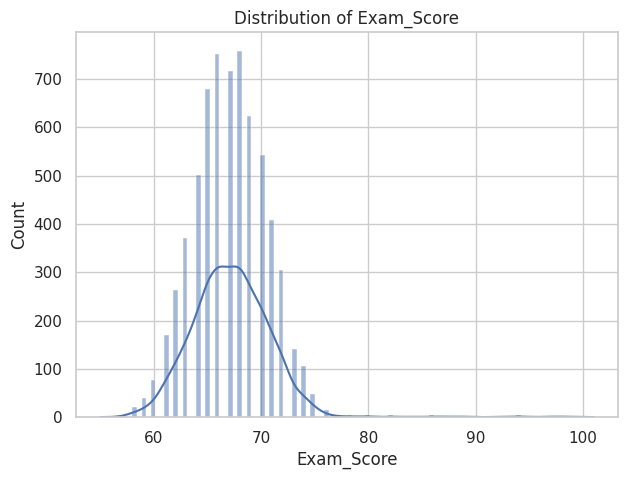

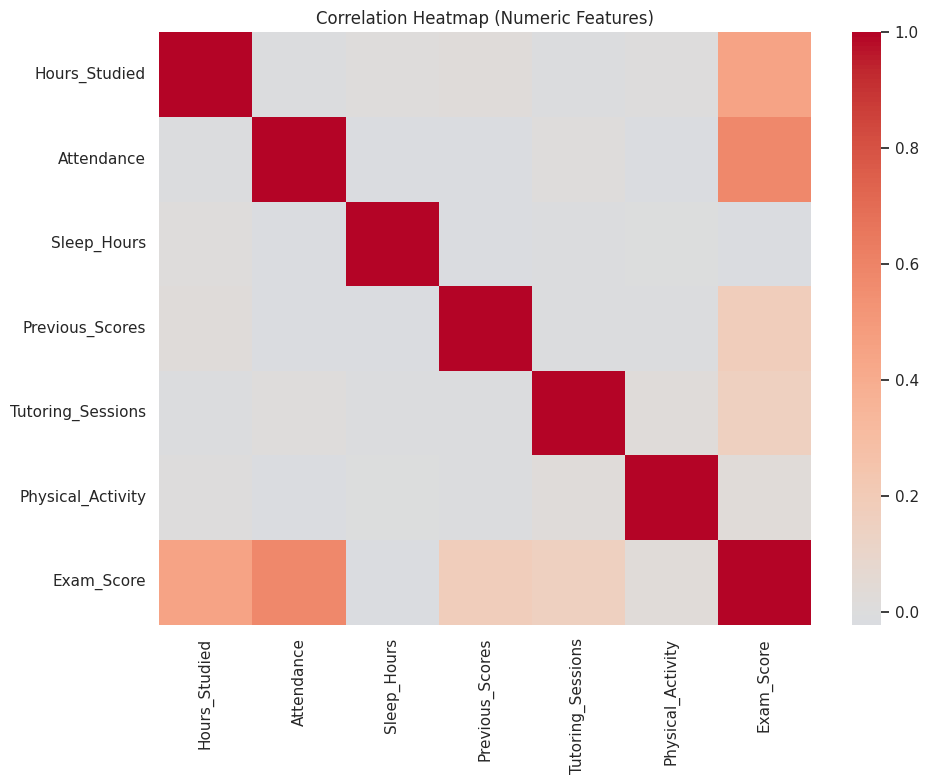

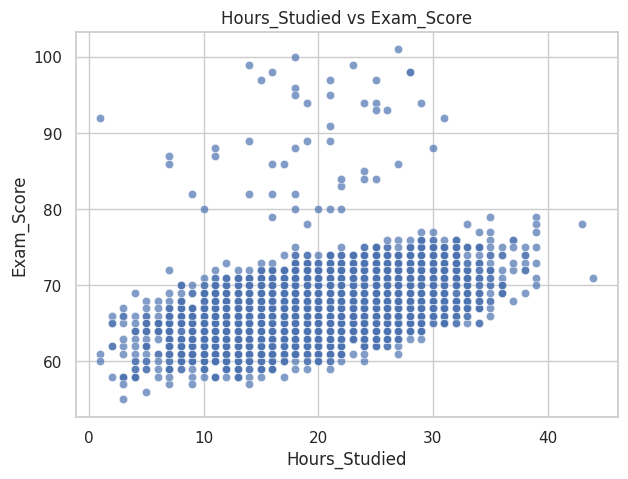

In [4]:

# Distribution of Exam_Score
plt.figure()
sns.histplot(df["Exam_Score"], kde=True)
plt.title("Distribution of Exam_Score")
plt.xlabel("Exam_Score")
plt.ylabel("Count")
plt.show()

# Correlation heatmap for numeric features
plt.figure(figsize=(10,8))
corr = df.select_dtypes(include=[np.number]).corr(numeric_only=True)
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()

# Scatter: Hours_Studied vs Exam_Score
if "Hours_Studied" in df.columns:
    plt.figure()
    sns.scatterplot(x=df["Hours_Studied"], y=df["Exam_Score"], alpha=0.7)
    plt.title("Hours_Studied vs Exam_Score")
    plt.xlabel("Hours_Studied")
    plt.ylabel("Exam_Score")
    plt.show()


## 5) Train/Test Split

In [5]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (5285, 19), Test shape: (1322, 19)


## 6) Model Training — Linear Regression


We use a **Pipeline** with preprocessing + **LinearRegression** to avoid data leakage and keep everything reproducible.


In [6]:

linreg_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

linreg_pipeline.fit(X_train, y_train)
print("✅ Linear Regression trained.")


✅ Linear Regression trained.


## 7) Evaluation


We report **MAE, MSE, RMSE, and R²** on the test set, plus a clean **Actual vs Predicted** plot.


🔎 Linear Regression — Test Metrics
MAE : 0.4524
MSE : 3.2560
RMSE: 1.8044
R²  : 0.7696


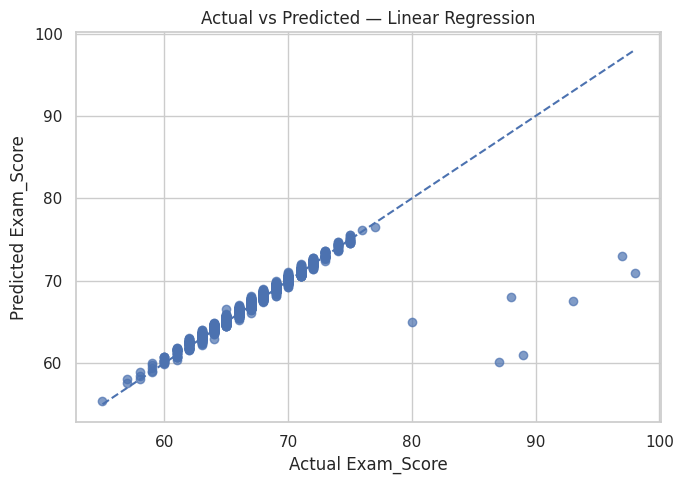

In [7]:

def evaluate(model, X_tr, X_te, y_tr, y_te, label="Model"):
    from math import sqrt
    y_pred = model.predict(X_te)
    mae = mean_absolute_error(y_te, y_pred)
    mse = mean_squared_error(y_te, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_te, y_pred)
    print(f"🔎 {label} — Test Metrics")
    print(f"MAE : {mae:.4f}")
    print(f"MSE : {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²  : {r2:.4f}")
    return y_pred, {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

y_pred_lin, lin_metrics = evaluate(linreg_pipeline, X_train, X_test, y_train, y_test, "Linear Regression")

# Actual vs Predicted
plt.figure()
plt.scatter(y_test, y_pred_lin, alpha=0.7)
mn, mx = min(y_test.min(), y_pred_lin.min()), max(y_test.max(), y_pred_lin.max())
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.title("Actual vs Predicted — Linear Regression")
plt.xlabel("Actual Exam_Score")
plt.ylabel("Predicted Exam_Score")
plt.tight_layout()
plt.show()


## 8) Polynomial Regression (Bonus)


To capture non-linear relationships in **numeric** features, we apply **PolynomialFeatures (degree=2)** to the numeric subset, while one-hot encoding the categorical features.  
This avoids explosive feature growth from interactions among one-hot columns.


In [8]:

# Build a specialized preprocessor: Polynomial on numerics, One-Hot on categoricals
poly_numeric = Pipeline(steps=[
    ("imputer", __import__("sklearn").impute.SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False))
])

poly_preprocessor = ColumnTransformer(
    transformers=[
        ("num_poly", poly_numeric, num_cols),
        ("cat_ohe", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ],
    remainder="drop"
)

poly_pipeline = Pipeline(steps=[
    ("preprocess", poly_preprocessor),
    ("model", LinearRegression())
])

poly_pipeline.fit(X_train, y_train)
print("✅ Polynomial Regression (degree=2) trained.")

y_pred_poly, poly_metrics = evaluate(poly_pipeline, X_train, X_test, y_train, y_test, "Polynomial Regression (deg=2)")


✅ Polynomial Regression (degree=2) trained.
🔎 Polynomial Regression (deg=2) — Test Metrics
MAE : 0.4662
MSE : 3.2738
RMSE: 1.8094
R²  : 0.7684


## 9) Feature Selection Experiment (Bonus)


Compare using only **`Hours_Studied`** vs **all features**.  
We re-train a minimalist pipeline with just one feature to highlight the incremental value of the full feature set.


In [9]:

if "Hours_Studied" in X.columns:
    X_h = X[["Hours_Studied"]].copy()
    X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
        X_h, y, test_size=0.2, random_state=RANDOM_STATE
    )

    single_num_preprocess = Pipeline(steps=[
        ("imputer", __import__("sklearn").impute.SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    hours_pipeline = Pipeline(steps=[
        ("preprocess", ColumnTransformer([("num", single_num_preprocess, ["Hours_Studied"])], remainder="drop")),
        ("model", LinearRegression())
    ])

    hours_pipeline.fit(X_train_h, y_train_h)
    y_pred_hours, hours_metrics = evaluate(hours_pipeline, X_train_h, X_test_h, y_train_h, y_test_h, "Linear Regression (Hours_Studied only)")
else:
    print("⚠️ 'Hours_Studied' not found. Skipping the one-feature experiment.")
    hours_metrics = None


🔎 Linear Regression (Hours_Studied only) — Test Metrics
MAE : 2.4476
MSE : 10.8559
RMSE: 3.2948
R²  : 0.2320


### (Optional) Model Insights — Feature Importance


For linear models with many one-hot columns, raw coefficients are hard to interpret.  
We use **Permutation Importance** on the test set (with caution) to get a relative ranking.


In [10]:

try:
    result = permutation_importance(linreg_pipeline, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE)
    importances = pd.DataFrame({
        "feature": X.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std
    }).sort_values("importance_mean", ascending=False)
    display(importances.head(15))
except Exception as e:
    print("Permutation importance failed (often due to column alignment with ColumnTransformer).", e)


,feature,importance_mean,importance_std
1,Attendance,0.744818,0.015641
0,Hours_Studied,0.453000,0.022193
3,Access_to_Resources,0.067365,0.005924
2,Parental_Involvement,0.066762,0.005146
6,Previous_Scores,0.066408,0.004483
9,Tutoring_Sessions,0.050054,0.003866
16,Parental_Education_Level,0.022350,0.001777
10,Family_Income,0.021048,0.003076
7,Motivation_Level,0.020617,0.002726
13,Peer_Influence,0.019850,0.001740


## 10) Conclusion


- A robust **Linear Regression** pipeline provides a strong baseline with proper preprocessing.  
- **Polynomial Regression (degree=2)** can capture mild non-linearities and may improve performance depending on the dataset signal-to-noise ratio.  
- **Feature selection** shows the incremental value of additional predictors beyond `Hours_Studied` alone.  

> **Deliverables Recap:**  
> - Clean, reproducible code with Pipeline/ColumnTransformer.  
> - Clear EDA visuals and metrics (MAE, MSE, RMSE, R²).  
> - Bonus experiments for model comparison and feature selection.
